# Analysis of Friedel Oscilations in the 1D density

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re,glob,os
from scipy import integrate
from numpy import pi as π
import dgutils
from pimcscripts import pimchelp
from collections import defaultdict
from scipy import interpolate
from dgutils import colors as colortools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# plot style
plot_style = {'aps':'../include/aps.mplstyle', 'notebook':'../include/notebook.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['notebook'])

figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ρ_col = [colors[0],colors[1],colors[-2]]
grey = '#4B4B4B'

from hg_utils import *

## Some Helper Functions

In [2]:
reduce_par = 'T = 2.00'

ΔR = [2.0,3.0,4.0] # radii we consider
L = 100.0 # pore length
R = 12.0 # pore radius
w = 3.0 # pinch width

## Load the QMC densities from disk

In [3]:
reduce_params = {'reduce':'T', 'L':100, 'μ':-7.2}

ρ_1d_qmc = {}
ρₒ_int = {}

estimator = {}
for cΔR in [0]+ΔR:
    ρ_1d_qmc[lab(cΔR)] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params, base_dir=repo_dir(cΔR),
                                                                       estimator='linedensity'))
    
    estimator[lab(cΔR)] = pimchelp.PIMCResults(pimchelp.get_reduce_name(**reduce_params, base_dir=repo_dir(cΔR),
                                                                       estimator='estimator'))
    
    reduce_par = ρ_1d_qmc[lab(cΔR)].params[0]
    
    # they all share a common first axis, we shift by L/2
    x = ρ_1d_qmc[lab(0.0)].x(reduce_par) - L/2
    x_mask_in = np.where(np.abs(x)<=2*w+1)[0]
    x_mask_out_left = np.where(x < -L/2+2*w)[0]
    x_mask_out_right = np.where(x > L/2-2*w)[0]
    
    x_mask_in_1sided = np.where((x>=0) & (x<2*w+1))[0]

    # The density obtained from integration
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
    #ρₒ_int[lab(cΔR)] = integrate.simpson(_ρ,x=_x)/L

    # get a rough average by integrating in the tails
    ρₒ_int[lab(cΔR)] = integrate.simpson(_ρ[x_mask_out_right],x=_x[x_mask_out_right])/(_x[x_mask_out_right[-1]] - _x[x_mask_out_right[0]])
    ρₒ_int[lab(cΔR)] += integrate.simpson(_ρ[x_mask_out_left],x=_x[x_mask_out_left])/(_x[x_mask_out_left[-1]] - _x[x_mask_out_left[0]])
    ρₒ_int[lab(cΔR)] /= 2

## Average the $x<0$ data with $x>0$ data

Here we leverage the fact that we have reflection symmetry around the pinch to improve statistics

In [4]:
start = int(len(x)/2)
end = len(x)

idx_pos = range(start,end-1)
idx_neg = range(start-1,0,-1)

ρ̄_1d = {}
Δρ̄_1d = {}
for cΔR in [0]+ΔR:
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
    
    ρ̄_1d[lab(cΔR)] = np.copy(_ρ)

    ρ̄_1d[lab(cΔR)][idx_neg] = 0.5*(_ρ[idx_pos] + _ρ[idx_neg])
    ρ̄_1d[lab(cΔR)][idx_pos] = 0.5*(_ρ[idx_pos] + _ρ[idx_neg])
    
    Δρ̄_1d[lab(cΔR)] = np.copy(_Δρ)
    Δρ̄_1d[lab(cΔR)][idx_neg] = 0.5*np.sqrt(_Δρ[idx_pos]**2 + _Δρ[idx_neg]**2) 
    Δρ̄_1d[lab(cΔR)][idx_pos] = 0.5*np.sqrt(_Δρ[idx_pos]**2 + _Δρ[idx_neg]**2)

## Density Oscillations

In [5]:
def plot_params(color, eb=True, alpha='80'):

    alpha_f = int(alpha,16)/255.0
    _p = {'marker':'o', 'linewidth':0.1, 'color':color, 
          'markerfacecolor':colortools.get_alpha_hex(color,alpha_f)+alpha, 'markersize':3, 
          'markeredgecolor':color, 'linestyle':':', 'markeredgewidth':0.5}
    if eb:
        _p['ecolor'] = color
        _p['elinewidth'] = 0.5
        _p['linestyle'] = 'None'
        _p['zorder'] = 10
        _p['barsabove'] = True

    return _p

In [6]:
def plot_ρ_1d(_ax,_x,_ρ,_Δρ,idxs,cΔR,_col,label='_nolegend_', line=True, shift=False, ave_ρ=0.0, Δave_ρ=0.0):
    
    if shift:
        _ρ,_Δρ = shifted_ave(_ρ,_Δρ,ave_ρ, Δave_ρ)
    
    if line:
        _ax.plot(x[idxs],_ρ[idxs], ls='-', lw=0.25, color=_col)
    
    _ax.errorbar(x[idxs],_ρ[idxs],yerr=_Δρ[idxs], **plot_params(_col), label=label)
    return _ax

## Plot a single $\delta R$ Value

In [7]:
def plot_single_ρ(ax,_x,_ρ,_Δρ,msk,cΔR,_col, shift=False, ave_ρ=0.0, plot0=False, xaxis=True, Δave_ρ=0.0, line=True):
    label =f'$\delta R = {cΔR:.1f}\;$'+r'${\rm \AA}$'
                
    # central portion 
    plot_ρ_1d(ax,_x,_ρ,_Δρ,range(msk[0],msk[-1]+1),cΔR,colortools.get_alpha_hex(_col,0.2),
              shift=shift,ave_ρ=ave_ρ, Δave_ρ=Δave_ρ, line=line)
        
    # x < -x_cut
    if msk[0] < int(len(x)/2):
        plot_ρ_1d(ax,_x,_ρ,_Δρ,range(msk[0]),cΔR,_col,shift=shift,ave_ρ=ave_ρ, Δave_ρ=Δave_ρ, line=line)
        
    # x > -x_cut
    plot_ρ_1d(ax,_x,_ρ,_Δρ,range(msk[-1],len(x)),cΔR,_col, label=label,shift=shift,ave_ρ=ave_ρ, 
              Δave_ρ=Δave_ρ, line=line)
    
    ax.legend(loc='upper right', borderpad=0)
    
    if shift:
        ax.set_ylabel(r'$\langle \delta \rho(x) \rangle / \rho_0$');
        
    else:    
        ax.set_ylabel(r'$\langle \rho(x) \rangle\; (\rm \AA^{-1})$');
     
    if xaxis:
        ax.set_xlabel(r'$x\; (\rm \AA)$');
    else:
        ax.xaxis.set_ticklabels([])
        ax.set_xlabel('');
    
    return ax

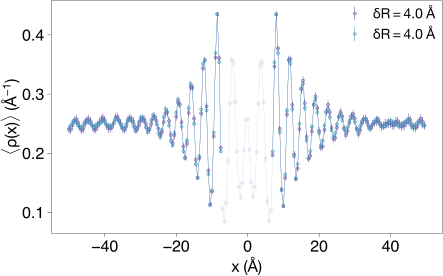

In [8]:
cΔR = 4.0

with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]))
    
    # raw data
    plot_single_ρ(ax,*ρ_1d_qmc[lab(cΔR)].epdata(reduce_par),x_mask_in,cΔR,ρ_col[0])
    
    # reflection symmetry averaged data
    plot_single_ρ(ax,x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)],x_mask_in,cΔR,ρ_col[1])

    #ax.set_xlim(35,50)
    #ax.set_ylim(0.22,0.28)

## Investigate the unpinched pore. 

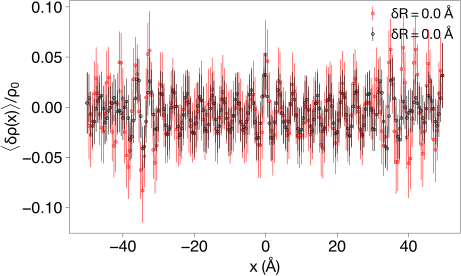

In [9]:
cΔR = 0.0

with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]))
    
    plot_single_ρ(ax,*ρ_1d_qmc[lab(cΔR)].epdata(reduce_par),range(0,1),cΔR,'#FF0000',shift=True,ave_ρ=ρₒ_int[lab(cΔR)])   
    plot_single_ρ(ax,x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)],range(0,1),cΔR,'#000000',shift=True,ave_ρ=ρₒ_int[lab(cΔR)],Δave_ρ=4E-4) 
    #ax.set_xlim(32,50)
    #ax.set_ylim(-0.06,0.06)
    #ax.set_ylim(-0.4,0.4)

## Plot various $\Delta R$ values

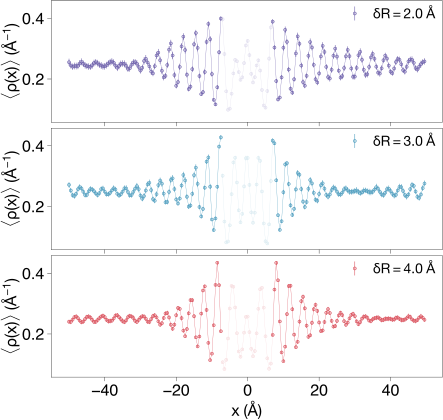

In [10]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    for i,cΔR in enumerate(ΔR):             
        plot_single_ρ(ax[i],*ρ_1d_qmc[lab(cΔR)].epdata(reduce_par),x_mask_in,cΔR,ρ_col[i])
        if i < 2:
            ax[i].set_xlabel('');

## Investigate the Fourier Transform of the signal

In [14]:
Δx = x[1]-x[0]

ρ̂_qmc = {}
ρ̂_qmc_clean = {}
k = 2*π*np.fft.rfftfreq(len(x),Δx)
kF = {}
ρₒ_qmc = {}
for cΔR in ΔR:

    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
    ρ̂_qmc[lab(cΔR)] = np.cos(0.5*L*k)*np.fft.rfft(_ρ-np.average(_ρ))*Δx
    
    kF[lab(cΔR)] = k[np.argmax(ρ̂_qmc[lab(cΔR)])]/2.0
    ρₒ_qmc[lab(cΔR)] = np.sum(_ρ)*Δx/L 
                     
    kF[lab(cΔR)] = π*ρₒ_qmc[lab(cΔR)]
    
    # compare
    #print(f'ΔR = {cΔR:.1f} Å : {kF[lab(cΔR)]/(π*ρₒ_qmc[lab(cΔR)]):.3f}')  
    
    # see what happens when we subtract the central portion
    ρ_clean = np.copy(_ρ)
    msk = x_mask_in
    ρ_clean[range(msk[0]-1,msk[-1]+1)] = 0.0
    ρ̂_qmc_clean[lab(cΔR)] = np.cos(0.5*L*k)*np.fft.rfft(ρ_clean-np.average(ρ_clean))*Δx

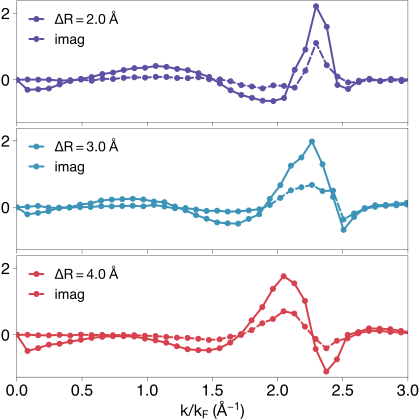

In [15]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    col = [colors[0],colors[1],colors[-2]]
    for i,cΔR in enumerate(ΔR):
        label =f'$\Delta R = {cΔR:.1f}\;$'+r'${\rm \AA}$'        
        ax[i].plot(k/kF[lab(cΔR)],ρ̂_qmc[lab(cΔR)].real,'o-',color=col[i], label=label)    
        ax[i].plot(k/kF[lab(cΔR)],ρ̂_qmc[lab(cΔR)].imag,'o--',color=col[i], label='imag')    
        
        # this represents the fourier transform without the middle
        #ax[i].plot(k/kF[lab(cΔR)],ρ̂_qmc_clean[lab(cΔR)].real,'o-', color='g', label=label)

        ax[i].legend()
        ax[i].set_xlim(0,3)

ax[-1].set_xlabel(r'$k/k_F\; (\rm \AA^{-1})$');

## Extract the maxima and minima outside the core region

In [11]:
from scipy.signal import argrelmax,argrelmin

ρ_max_arg = defaultdict(list)
ρ_min_arg = defaultdict(list)

for cΔR in ΔR:
        
    # don't use mirror symmetry
    _x,_ρ,_Δρ = ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    # use mirror symmetry
    _x,_ρ,_Δρ = x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)]
    
    idxs = list(range(x_mask_in[0]+1)) + list(range(x_mask_in[-1]+1,len(x)))
    max_arg = argrelmax(_ρ)[0]
    min_arg = argrelmin(_ρ)[0]
    
    x_cut_indices = x_mask_in
    
    ρ_max_arg[lab(cΔR)] = [carg for carg in max_arg if carg not in x_cut_indices]
    ρ_min_arg[lab(cΔR)] = [carg for carg in min_arg if carg not in x_cut_indices]

## Replot the density with the envelope

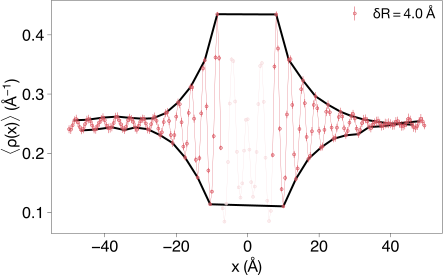

In [12]:
cΔR = 4.0

with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]))
    
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    plot_single_ρ(ax,_x,_ρ,_Δρ,x_mask_in,cΔR,ρ_col[-1])
    ax.plot(x[ρ_max_arg[lab(cΔR)]],_ρ[ρ_max_arg[lab(cΔR)]],'-k')
    ax.plot(x[ρ_min_arg[lab(cΔR)]],_ρ[ρ_min_arg[lab(cΔR)]],'-k')

## Determine an average density from the tails

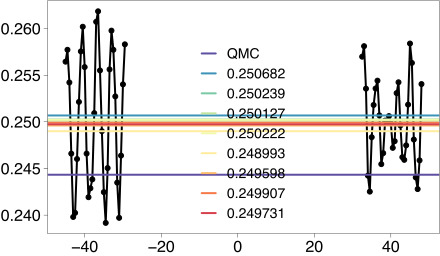

In [16]:
ρₒ_ave = {}
Δρₒ_ave = {}

for cΔR in ΔR:

    tρₒ = []
    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 

    # first average max-to-max
    for num_peaks in range(1,5):
        neg_max_start,neg_max_end = ρ_max_arg[lab(cΔR)][1],ρ_max_arg[lab(cΔR)][num_peaks+1]
        pos_max_start,pos_max_end = ρ_max_arg[lab(cΔR)][-1-num_peaks],ρ_max_arg[lab(cΔR)][-1]
        tρₒ.append(np.average(
            np.hstack((_ρ[neg_max_start:neg_max_end+1],_ρ[pos_max_start:pos_max_end+1]))))
        
    # then min-to-min
    for num_troughs in range(1,5):
        neg_min_start,neg_min_end = ρ_min_arg[lab(cΔR)][1],ρ_min_arg[lab(cΔR)][num_troughs+1]
        pos_min_start,pos_min_end = ρ_min_arg[lab(cΔR)][-1-num_troughs],ρ_min_arg[lab(cΔR)][-1]
        tρₒ.append(np.average(
            np.hstack((_ρ[neg_min_start:neg_min_end+1],_ρ[pos_min_start:pos_min_end+1]))))
        
    ρₒ_ave[lab(cΔR)] = np.average(tρₒ)
    Δρₒ_ave[lab(cΔR)] = np.std(tρₒ)

with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[1]))

    _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    ax.plot(x[neg_max_start:neg_max_end+1],_ρ[neg_max_start:neg_max_end+1],'-ko')
    ax.plot(x[pos_max_start:pos_max_end+1],_ρ[pos_max_start:pos_max_end+1],'-ko')
    
    ax.axhline(y=ρₒ_qmc[lab(cΔR)], label='QMC')
    
    for i,ct in enumerate(tρₒ):
        ax.axhline(y=ct, color=colors[i+1], label=f'{ct:8.6f}')
    ax.legend()

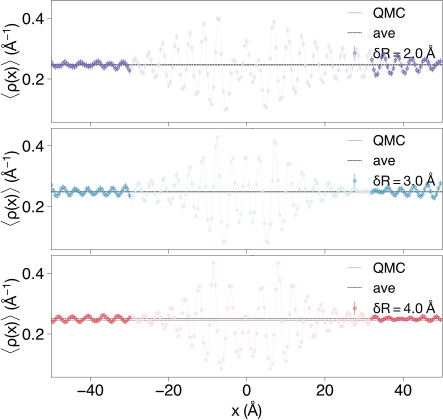

In [17]:
plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=True, figsize=(figsize[0],figsize[0]))
    plt.subplots_adjust(hspace=0.05)
    
    for i,cΔR in enumerate(ΔR):
        _x,_ρ,_Δρ =  ρ_1d_qmc[lab(cΔR)].epdata(reduce_par)
        
        
        ax[i].axhline(y=ρₒ_qmc[lab(cΔR)], label='QMC', color='grey', ls='--', lw=0.5)
        ax[i].axhline(y=ρₒ_ave[lab(cΔR)], label='ave', color='k', ls='--', lw=0.5)
        
        plot_single_ρ(ax[i],_x,_ρ,_Δρ,range(neg_max_end,pos_max_start),cΔR,ρ_col[i])
        
    ax[-1].set_xlim(-50,50)

## Investigate Friedel Oscillations

We use the LL parameter reported in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.105303

$a \equiv 1/\rho_0$

In [18]:
K = 1.3
a = {}
for cΔR in ΔR:
    a[lab(cΔR)] = 1.0/ρₒ_ave[lab(cΔR)]

In [19]:
from scipy.special import beta as B
from scipy.special import exp1

# The cord length
def D(_x):
    return (L/π)*np.sin(π*np.abs(_x) / L)

# Reduced decay part
def D̄(_x,a):
    α = a*K/(2*π)
    cx = D(_x)

    return (1+cx/α)

def δρPBC(_x,K,y,a):
    α = a*K/(2*π)
    cx = D(_x)
    
    return (1.0/a) * 2**(2/K) * (K/2) * y * B(0.5,1.0/K-0.5) * (1+cx/α)**(1.0-2.0/K) * np.cos(2.0*π*_x/a)

def δρPBC_envelope(_x,K,y,a):
    α = a*K/(2*π)
    cx = D(_x)

    return (1.0/a) * 2**(2/K) * (K/2) * y * B(0.5,1.0/K-0.5) * (1+cx/α)**(1.0-2.0/K)

def δρoρₒPBC_envelope(_x,K,y,a):
    α = a*K/(2*π)
    cx = D(_x)

    return 2**(2/K) * (K/2) * y * B(0.5,1.0/K-0.5) * (1+cx/α)**(1.0-2.0/K)

def prefac(K):
    return 2**(2/K) * (K/2) * B(0.5,1.0/K-0.5)

### First we get the data set (envelope) that we will fit to

In [20]:
x_pos_max,x_pos_min = {},{}
ρ_pos_max,ρ_pos_min = {},{}
Δρ_pos_max,Δρ_pos_min = {},{}

x_neg_max,x_neg_min = {},{}
ρ_neg_max,ρ_neg_min = {},{}
Δρ_neg_max,Δρ_neg_min = {},{}

x_env_fit = {}
ρ_env_fit = {}
Δρ_env_fit = {}

x_cut = 5.0

for cΔR in ΔR:
    
    # don't use mirror symmetry
    #_x,_ρ,_Δρ = ρ_1d_qmc[lab(cΔR)].epdata(reduce_par) 
    
    # use mirror symmetry
    _x,_ρ,_Δρ = x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)]
    
    # to compute the error in the reduced density
    norm2 = (Δρₒ_ave[lab(cΔR)]/ρₒ_ave[lab(cΔR)])**2

    idx = [i for i in ρ_max_arg[lab(cΔR)] if _x[i] > x_cut]
    x_pos_max[lab(cΔR)] = _x[idx]
    ρ_pos_max[lab(cΔR)],Δρ_pos_max[lab(cΔR)] = shifted_ave(_ρ[idx],_Δρ[idx],ρₒ_ave[lab(cΔR)],Δρₒ_ave[lab(cΔR)])
    
    idx = [i for i in ρ_min_arg[lab(cΔR)] if _x[i] > x_cut]
    x_pos_min[lab(cΔR)] = _x[idx]
    ρ_pos_min[lab(cΔR)],Δρ_pos_min[lab(cΔR)] = shifted_ave(_ρ[idx],_Δρ[idx],ρₒ_ave[lab(cΔR)],Δρₒ_ave[lab(cΔR)])
    ρ_pos_min[lab(cΔR)] *= -1

    idx = [i for i in ρ_max_arg[lab(cΔR)] if _x[i] < -x_cut]
    x_neg_max[lab(cΔR)] = _x[idx]
    ρ_neg_max[lab(cΔR)],Δρ_neg_max[lab(cΔR)] = shifted_ave(_ρ[idx],_Δρ[idx],ρₒ_ave[lab(cΔR)],Δρₒ_ave[lab(cΔR)])      
    
    idx = [i for i in ρ_min_arg[lab(cΔR)] if _x[i] < -x_cut]
    x_neg_min[lab(cΔR)] = _x[idx]
    ρ_neg_min[lab(cΔR)],Δρ_neg_min[lab(cΔR)] = shifted_ave(_ρ[idx],_Δρ[idx],ρₒ_ave[lab(cΔR)],Δρₒ_ave[lab(cΔR)])
    ρ_neg_min[lab(cΔR)] *= -1
    
    # combine all the data together 
    x_env_fit[lab(cΔR)] = np.hstack((x_pos_max[lab(cΔR)],x_pos_min[lab(cΔR)],x_neg_max[lab(cΔR)],x_neg_min[lab(cΔR)]))
    ρ_env_fit[lab(cΔR)] = np.hstack((ρ_pos_max[lab(cΔR)],ρ_pos_min[lab(cΔR)],ρ_neg_max[lab(cΔR)],ρ_neg_min[lab(cΔR)]))
    Δρ_env_fit[lab(cΔR)] = np.hstack((Δρ_pos_max[lab(cΔR)],Δρ_pos_min[lab(cΔR)],Δρ_neg_max[lab(cΔR)],Δρ_neg_min[lab(cΔR)]))
    
    # sort the values of the maxima and minima
    idx_sort = np.argsort(x_env_fit[lab(cΔR)])
    x_env_fit[lab(cΔR)] = x_env_fit[lab(cΔR)][idx_sort]
    ρ_env_fit[lab(cΔR)] = ρ_env_fit[lab(cΔR)][idx_sort]
    Δρ_env_fit[lab(cΔR)] = Δρ_env_fit[lab(cΔR)][idx_sort]

## Extract the larger power law

In [21]:
from scipy.optimize import curve_fit

def initial_decay_pl(x, a, b):
    return a * x ** (-b)

def initial_decay(x, a, b):
    return a * np.exp(-b*np.abs(x))

def ll_decay(_x,y):
    δρoρₒPBC_envelope(_x,1.3,y,1.0/ρₒ_ave[lab(cΔR)])

### We just consider the 1-sided decay exploiting mirror symmetry.

#### We begin with the fast exponential decay

In [22]:
cΔR = 4.0

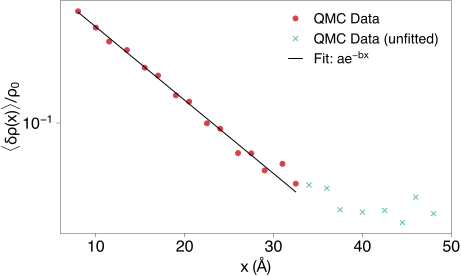

In [23]:
x_cut_pos_idx = np.where(x_env_fit[lab(cΔR)]>=x_cut)[0][0]
x_pos_end = np.where(x_env_fit[lab(cΔR)]>=x[ρ_max_arg[lab(cΔR)][-5]])[0][0]

exp_end = x_pos_end

popt, pcov = curve_fit(initial_decay, np.abs(x_env_fit[lab(cΔR)][x_cut_pos_idx:x_pos_end+1]), ρ_env_fit[lab(cΔR)][x_cut_pos_idx:x_pos_end+1], 
                       sigma=Δρ_env_fit[lab(cΔR)][x_cut_pos_idx:x_pos_end+1], p0=[1,0.1])
pos_par = np.copy(popt)
Δpos_par = np.sqrt(np.diag(pcov))

plt.style.reload_library()
with plt.style.context(plot_style['notebook']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots()

    ax.plot(x_env_fit[lab(cΔR)][x_cut_pos_idx:x_pos_end+1],ρ_env_fit[lab(cΔR)][x_cut_pos_idx:x_pos_end+1], 'o', label='QMC Data', color=ρ_col[-1])
    ax.plot(x_env_fit[lab(cΔR)][x_pos_end+1:],ρ_env_fit[lab(cΔR)][x_pos_end+1:], 'x', label='QMC Data (unfitted)', color='#64be94')

    fit_x_exp = np.linspace(x_env_fit[lab(cΔR)][x_cut_pos_idx],x_env_fit[lab(cΔR)][x_pos_end],1000)
    ax.plot(fit_x_exp,initial_decay(fit_x_exp,*pos_par), label='Fit: $a \mathrm{e}^{-b x}$', color='k', lw=1)
    ax.set_xlabel(r'$x\; (\rm \AA)$');
    ax.set_ylabel(r'$\langle \delta \rho(x) \rangle / \rho_0$');
    ax.legend()
    ax.set_yscale("log")

#### Now we move to the harder power-law Luttinger liquid decay.

y = 0.01800741613304688 69.52314406939101


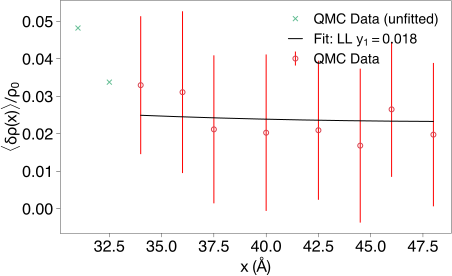

In [24]:
start_idx = ρ_min_arg[lab(cΔR)][-4]
end_idx = ρ_max_arg[lab(cΔR)][-1]

start = x[start_idx]
end = x[end_idx]

x_pos_start = np.where(x_env_fit[lab(cΔR)]>=start)[0][0]
x_pos_end = np.where(x_env_fit[lab(cΔR)]>=end)[0][0]

# store these values for later use
LL_fit_minmax_idx = [start_idx,end_idx]
LL_fit_x = [start,end]
LL_fit_env_idx = [x_pos_start,x_pos_end]

# peform the powerlaw "fit", really just the magnitude of the envelope as K is fixed from previous simulations
popt, pcov = curve_fit(δρoρₒPBC_envelope, x_env_fit[lab(cΔR)][x_pos_start:x_pos_end+1], ρ_env_fit[lab(cΔR)][x_pos_start:x_pos_end+1], 
                      sigma=Δρ_env_fit[lab(cΔR)][x_pos_start:x_pos_end+1], bounds=([K-1E-9,0,a[lab(cΔR)]-1E-9],[K+1E-9,0.1,a[lab(cΔR)]+1E-9]))

y_pos = popt[1]
Δy_pos = np.sqrt(pcov[1,1])
print('y =',y_pos,Δy_pos)

with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots()

    ax.plot(x_env_fit[lab(cΔR)][x_pos_start-2:x_pos_start],ρ_env_fit[lab(cΔR)][x_pos_start-2:x_pos_start], 'x', color='#64be94')
    ax.errorbar(x_env_fit[lab(cΔR)][x_pos_start:x_pos_end+1],ρ_env_fit[lab(cΔR)][x_pos_start:x_pos_end+1], 
                yerr=Δρ_env_fit[lab(cΔR)][x_pos_start:x_pos_end+1], marker='o', 
                linestyle='None', label='QMC Data', color=ρ_col[-1], mfc='None', ecolor='red',
                elinewidth=1)
               
    ax.plot(x_env_fit[lab(cΔR)][x_pos_end+1:],ρ_env_fit[lab(cΔR)][x_pos_end+1:], 'x', label='QMC Data (unfitted)', color='#64be94')

    fit_x_LL = np.linspace(x_env_fit[lab(cΔR)][x_pos_start],x_env_fit[lab(cΔR)][x_pos_end],1000)

    ax.plot(fit_x_LL,δρoρₒPBC_envelope(fit_x_LL,K,y_pos,a[lab(cΔR)]), label=f'Fit: LL $y_1 = {y_pos:.3f}$', color='k', lw=1)
    ax.set_xlabel(r'$x\; (\rm \AA)$');
    ax.set_ylabel(r'$\langle \delta \rho(x) \rangle / \rho_0$');

    ax.legend()
    #ax.set_xlim(32,50)
    #ax.set_ylim(-0.6,0.6)
    #ax.set_yscale("log")
    #ax.set_xscale("log")

## A Combined Plot to Highlight the Fitting

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


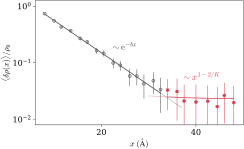

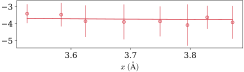

In [25]:
def plot_fit_analysis(ax, LL_label='top', xaxis=True):

    # envelope data - exp decay
    ax.plot(fit_x_exp,initial_decay(fit_x_exp,*pos_par), color=grey, lw=0.75, zorder=-200)
    
    idxs = range(x_cut_pos_idx,exp_end+1)
    ax.errorbar(x_env_fit[lab(cΔR)][idxs],ρ_env_fit[lab(cΔR)][idxs],
                 yerr=Δρ_env_fit[lab(cΔR)][idxs], **plot_params(grey))

    # envelope data - powerlaw decay
    idxs = range(LL_fit_env_idx[0],LL_fit_env_idx[1]+1)
    ax.errorbar(x_env_fit[lab(cΔR)][idxs],ρ_env_fit[lab(cΔR)][idxs],
                 yerr=Δρ_env_fit[lab(cΔR)][idxs], **plot_params(ρ_col[-1], alpha='FF'))    

    fit_x_exp2 = np.linspace(fit_x_exp[-1],37,1000)
    ax.plot(fit_x_exp2,initial_decay(fit_x_exp2,*pos_par),linestyle=':', color=grey+'80', lw=0.75)
    ax.text(22,0.17,'$\sim \mathrm{e}^{-b x}$', color=grey)

    ## LL Fit
    fit_x_LL2 = np.linspace(30,fit_x_LL[0],1000)
    ax.plot(fit_x_LL,δρoρₒPBC_envelope(fit_x_LL,K,y_pos,a[lab(cΔR)]), color=ρ_col[-1], lw=0.75)
    ax.plot(fit_x_LL2,δρoρₒPBC_envelope(fit_x_LL2,K,y_pos,a[lab(cΔR)]), color=ρ_col[-1]+'80', linestyle=':', lw=0.75)
    
    if LL_label == 'top':
        ax.text(37,0.05,'$\sim x^{1-2/K}$', color=ρ_col[-1])
    else:
        ax.text(33.2,0.05,'$\sim x^{1-2/K}$', color=ρ_col[-1])

    if xaxis:
        ax.set_xlabel(r'$x\; (\rm \AA)$');
    
    ax.set_ylabel(r'$\langle \delta \rho(x) \rangle / \rho_0$');
    ax.set_ylim(8E-3,1.25)
    ax.set_yscale("log")
        
def plot_fit_analysis_LL(ax, LL_label='top', xaxis=True):

        # envelope data
        idxs = range(LL_fit_env_idx[0],LL_fit_env_idx[1]+1)
        
        ax.errorbar(np.log(x_env_fit[lab(cΔR)][idxs]),np.log(ρ_env_fit[lab(cΔR)][idxs]),
                     yerr=np.abs(Δρ_env_fit[lab(cΔR)][idxs]/ρ_env_fit[lab(cΔR)][idxs]), 
                    **plot_params(ρ_col[-1]))

        ## LL Fit
        fit_x_LL2 = np.linspace(LL_fit_x[0],LL_fit_x[1],1000)
        ax.plot(np.log(fit_x_LL2),np.log(δρoρₒPBC_envelope(fit_x_LL2,K,y_pos,a[lab(cΔR)])), color=ρ_col[-1], lw=0.75)

        if xaxis:
            ax.set_xlabel(r'$x\; (\rm \AA)$');

        
with plt.style.context(plot_style['aps']):

    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=figsize, constrained_layout=True)
    
    plot_fit_analysis(ax)
    
    plt.savefig(f'../figures/fit_envelope_{lab(cΔR)}.pdf')
    

with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=(figsize[0],0.5*figsize[1]), constrained_layout=True)
    
    plot_fit_analysis_LL(ax)
        

## Combine the LL Fit with the Data

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


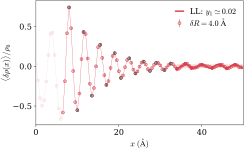

In [26]:
def plot_friedel(ax, xaxis=True, envelope=False):
    # use mirror symmetry
    _x,_ρ,_Δρ = x,ρ̄_1d[lab(cΔR)],Δρ̄_1d[lab(cΔR)]

    if envelope:
        mask_idx = [i for i in ρ_max_arg[lab(cΔR)] if _x[i] > x_cut and _x[i] < LL_fit_x[0]]
        mask_idx += [i for i in ρ_min_arg[lab(cΔR)] if _x[i] > x_cut and _x[i] < LL_fit_x[0]]
        mask_idx = np.array(mask_idx)

    plot_single_ρ(ax,_x,_ρ,_Δρ,x_mask_in_1sided,cΔR,ρ_col[-1],shift=True,ave_ρ=ρₒ_ave[lab(cΔR)],
                  Δave_ρ=Δρₒ_ave[lab(cΔR)], xaxis=xaxis)

    t_x = np.linspace(LL_fit_x[0],50,1000)

    # shaded LL envelope
    ax.fill_between(t_x,-δρoρₒPBC_envelope(t_x,K,y_pos,a[lab(cΔR)]),δρoρₒPBC_envelope(t_x,K,y_pos,a[lab(cΔR)]), 
                     facecolor=ρ_col[-1], alpha=0.2)

    # Friedel Prediction
    ax.plot(t_x,δρPBC(t_x,K,y_pos,a[lab(cΔR)])*a[lab(cΔR)],zorder=10,color=ρ_col[-1],lw=1.5, label=f'LL: $y_1 \simeq {y_pos:.2f}$')

    # Highlight the envelope points
    if envelope:

        # envelope data - exp decay
        idx = np.where(x_pos_min[lab(cΔR)] < LL_fit_x[0])[0]
        ax.errorbar(x_pos_min[lab(cΔR)][idx],-ρ_pos_min[lab(cΔR)][idx],
                     yerr=Δρ_pos_min[lab(cΔR)][idx], **plot_params(grey))

        idx = np.where(x_pos_max[lab(cΔR)] < LL_fit_x[0])[0]
        ax.errorbar(x_pos_max[lab(cΔR)][idx],ρ_pos_max[lab(cΔR)][idx],
                     yerr=Δρ_pos_max[lab(cΔR)][idx], **plot_params(grey))

        # LL data - powerlaw decay
        idx = np.where((x_pos_min[lab(cΔR)] >= LL_fit_x[0]) & (x_pos_min[lab(cΔR)] <= LL_fit_x[-1]))[0]
        ax.plot(x_pos_min[lab(cΔR)][idx],-ρ_pos_min[lab(cΔR)][idx], marker='o', color=ρ_col[-1], mfc=ρ_col[-1], 
                ms=3, linestyle='None', mew=0.5, zorder=100)
        idx = np.where((x_pos_max[lab(cΔR)] >= LL_fit_x[0]) & (x_pos_max[lab(cΔR)] <= LL_fit_x[-1]))[0]
        ax.plot(x_pos_max[lab(cΔR)][idx],ρ_pos_max[lab(cΔR)][idx], marker='o', color=ρ_col[-1], mfc=ρ_col[-1], 
                ms=3, linestyle='None', mew=0.5, zorder=100)
    
    ax.set_xlim(0,49.99)
    ax.legend()

with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize'] 
    fig,ax = plt.subplots(constrained_layout=True)
    
    plot_friedel(ax, envelope=True)
    plt.savefig(f'../figures/friedel_oscillations_{lab(cΔR)}.pdf')

## Combined Plot Reversed No Inset

TeX  NOT subset; don't know how to subset; dropped
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


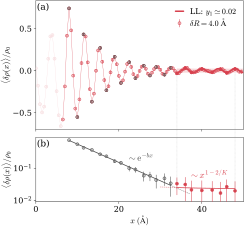

In [27]:
with plt.style.context(plot_style['aps']):
    
    fig, axs = plt.subplot_mosaic([['(a)'],['(a)'],['(b)']],layout='constrained', 
                                  figsize=(figsize[0],1.5*figsize[1]), sharex=True,
                                 gridspec_kw={"hspace": -0.2,})

    for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans)
        
    plot_friedel(axs['(a)'],xaxis=False, envelope=True)
    axs['(a)'].set_ylim(-0.7,0.83)

    plot_fit_analysis(axs['(b)'])
    axs['(b)'].set_xlabel('')
    axs['(b)'].set_ylim(9E-3,0.9)

    #axs['(b)'].xaxis.set_major_locator(AutoLocator())
    axs['(b)'].set_xlabel(r'$x\; (\rm \AA)$');
    axs['(b)'].set_xticks([0,20,40])
    axs['(b)'].set_xticklabels([0,20,40])
    
    # add lines showing the plot boundaries
    idx_start = LL_fit_minmax_idx[0]
    idx_end = LL_fit_minmax_idx[1]

    x_pos_start = LL_fit_env_idx[0]
    x_pos_end = LL_fit_env_idx[1]
    
    xy = (x[idx_start], -ρ_env_fit[lab(cΔR)][x_pos_start])
    xytext = (x[idx_start], np.abs(ρ_env_fit[lab(cΔR)][x_pos_start]))
    
    axs['(a)'].annotate("", xy=xy, xycoords='data',zorder=100, xytext=xytext, textcoords=axs['(b)'].transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                connectionstyle="arc3", color='gray', ls=':',lw=0.5, alpha=0.3))

    xy = (x[idx_end], -ρ_env_fit[lab(cΔR)][x_pos_end])
    xytext = (x[idx_end], np.abs(ρ_env_fit[lab(cΔR)][x_pos_end]))
    axs['(a)'].annotate("", xy=xy, xycoords='data',zorder=100, xytext=xytext, textcoords=axs['(b)'].transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                connectionstyle="arc3", color='gray', ls=':',lw=0.5, alpha=0.3))
    
    axs['(b)'].zorder = -100
    
    plt.savefig(f'../figures/combined_fit_friedel_{lab(cΔR)}_reversed_no_inset.pdf')

## Combined plot

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


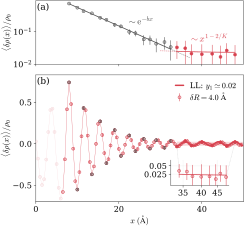

In [53]:
import matplotlib.transforms as mtransforms

with plt.style.context(plot_style['aps']):
    
    fig, axs = plt.subplot_mosaic([['(a)'], ['(b)'],['(b)']],layout='constrained', 
                                  figsize=(figsize[0],1.5*figsize[1]), sharex=True,
                                 gridspec_kw={"hspace": -0.2,})

    for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans)
        
    plot_fit_analysis(axs['(a)'])
    axs['(a)'].set_xlabel('')
    axs['(a)'].set_ylim(9.99E-3,0.9)
    
    plot_friedel(axs['(b)'], envelope=True)
    axs['(b)'].set_ylim(-0.7,0.83)
    
    axins = inset_axes(axs['(b)'], width="100%", height="100%",
                    bbox_to_anchor=(.67, .16, .28, .2),bbox_transform=axs['(b)'].transAxes)
    
    plot_fit_analysis_LL(axins, xaxis=False)
    
    axins.set_ylabel('')
    axins.set_xlim(np.log(32),np.log(49))
    axins.set_xticks([np.log(35),np.log(40),np.log(45)])
    axins.set_xticklabels(['35','40','45'])
    
    axins.set_ylim([np.log(0.0099),np.log(0.08)])
    axins.set_yticks([np.log(0.025),np.log(0.05)])
    axins.set_yticklabels(['0.025','0.05'])
    axins.spines[['right', 'top']].set_visible(False)
    
    # add lines showing the plot boundaries
    idx_start = LL_fit_minmax_idx[0]
    idx_end = LL_fit_minmax_idx[1]

    x_pos_start = LL_fit_env_idx[0]
    x_pos_end = LL_fit_env_idx[1]
    
    xy = (np.log(x[idx_start]), np.log(ρ_env_fit[lab(cΔR)][x_pos_start]))
    xytext = (start, ρ̄_1d[lab(cΔR)][idx_start]/ρₒ_ave[lab(cΔR)]-1)
    
    axins.annotate("", xy=xy, xycoords='data',zorder=-100, xytext=xytext, textcoords=axs['(b)'].transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                connectionstyle="arc3", color='gray', ls=':', alpha=0.3,lw=0.5))
    
    xy = (np.log(x[idx_end]), np.log(ρ_env_fit[lab(cΔR)][x_pos_end]))
    xytext = (end, ρ̄_1d[lab(cΔR)][idx_end]/ρₒ_ave[lab(cΔR)]-1)
    axins.annotate("", xy=xy, xycoords='data',zorder=-100, xytext=xytext, textcoords=axs['(b)'].transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                connectionstyle="arc3", color='gray', ls=':', alpha=0.3,lw=0.5))
    axins.grid(alpha=0.1)
    
    plt.savefig(f'../figures/combined_fit_friedel_{lab(cΔR)}.pdf')

## Combined Plot Reversed

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


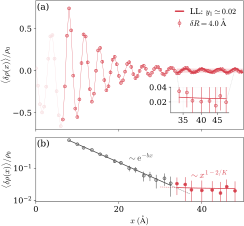

In [54]:
from matplotlib.ticker import AutoLocator

with plt.style.context(plot_style['aps']):
    
    fig, axs = plt.subplot_mosaic([['(a)'],['(a)'],['(b)']],layout='constrained', 
                                  figsize=(figsize[0],1.5*figsize[1]), sharex=True,
                                 gridspec_kw={"hspace": -0.2,})

    for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(1/72, -9/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans)
        
    plot_friedel(axs['(a)'],xaxis=False)
    axs['(a)'].set_ylim(-0.7,0.83)

    plot_fit_analysis(axs['(b)'])
    axs['(b)'].set_xlabel('')
    axs['(b)'].set_ylim(9E-3,0.9)

    #axs['(b)'].xaxis.set_major_locator(AutoLocator())
    axs['(b)'].set_xlabel(r'$x\; (\rm \AA)$');
    axs['(b)'].set_xticks([0,20,40])
    axs['(b)'].set_xticklabels([0,20,40])

    
    axins = inset_axes(axs['(a)'], width="100%", height="100%",
                    bbox_to_anchor=(.67, .16, .28, .2),bbox_transform=axs['(a)'].transAxes)
    
    plot_fit_analysis_LL(axins, xaxis=False)
    
    axins.set_ylabel('')
    axins.set_xlim(np.log(32),np.log(49))
    axins.set_xticks([np.log(35),np.log(40),np.log(45)])
    axins.set_xticklabels(['35','40','45'])
    
    axins.set_ylim([np.log(0.012),np.log(0.04)])
    axins.set_yticks([np.log(0.02),np.log(0.04)])
    axins.set_yticklabels(['0.02','0.04'])
    axins.spines[['right', 'top']].set_visible(False)
    
    # add lines showing the plot boundaries
    idx_start = LL_fit_minmax_idx[0]
    idx_end = LL_fit_minmax_idx[1]

    x_pos_start = LL_fit_env_idx[0]
    x_pos_end = LL_fit_env_idx[1]
    
    xy = (np.log(x[idx_start]), np.log(ρ_env_fit[lab(cΔR)][x_pos_start]))
    xytext = (start, ρ̄_1d[lab(cΔR)][idx_start]/ρₒ_ave[lab(cΔR)]-1)
    
    axins.annotate("", xy=xy, xycoords='data',zorder=-100, xytext=xytext, textcoords=axs['(a)'].transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                connectionstyle="arc3", color='gray', ls=':', alpha=0.3,lw=0.5))
    
    xy = (np.log(x[idx_end]), np.log(ρ_env_fit[lab(cΔR)][x_pos_end]))
    xytext = (end, ρ̄_1d[lab(cΔR)][idx_end]/ρₒ_ave[lab(cΔR)]-1)
    axins.annotate("", xy=xy, xycoords='data',zorder=-100, xytext=xytext, textcoords=axs['(a)'].transData,
                arrowprops=dict(arrowstyle="-", shrinkA=0,shrinkB=0,
                connectionstyle="arc3", color='gray', ls=':', alpha=0.3,lw=0.5))
    axins.grid(alpha=0.1)
    
    plt.savefig(f'../figures/combined_fit_friedel_{lab(cΔR)}_reversed.pdf')